# Basic dynamical evolution

In [1]:
import numpy as np
import freegs
import matplotlib.pyplot as plt
from copy import deepcopy
from IPython.display import display, clear_output
import time

%load_ext autoreload
%autoreload 2

In [2]:
# Create the machine.

# First, identify files containing the machine description.
# freeGSNKE requires the user to define the following environment variables 
# ACTIVE_COILS_PATH
# PASSIVE_COILS_PATH
# WALL_PATH
# LIMITER_PATH
# These define the machine geometry and properties.
import os
os.environ["ACTIVE_COILS_PATH"] = "../machine_configs/MAST-U/active_coils_from_UDA.pickle"
os.environ["PASSIVE_COILS_PATH"] = "../machine_configs/MAST-U/passive_coils_from_fiesta_filaments.pickle"
os.environ["WALL_PATH"] = "../machine_configs/MAST-U/wall.pickle"
os.environ["LIMITER_PATH"] = "../machine_configs/MAST-U/limiter.pickle"

# Now the machine can actually be built:
from freegsnke import build_machine
tokamak = build_machine.tokamak()



# Create the equilibrium and profile objects

# Creates the equilibrium object. 
# The equilibrium object indirectly defines the rectangular domain of the solver,
# as well as the grid resolution. 
eq = freegs.Equilibrium(tokamak=tokamak, #this assigns the machine just created above to the equilibrium
                        # the following define the rectangular domain
                        Rmin=0.1, Rmax=2.0,    # Radial range
                        Zmin=-2.2, Zmax=2.2,   # Vertical range
                        #grid resolution 
                        nx=65, # Number of grid points in the radial direction
                        ny=129, # Number of grid points in the vertical direction
                        # If available, an initial plasma flux function "plasma_psi" can be provided:
                        # psi=initial guess plasma_psi
                        )  


# Creates the profile object. 
# The profile object sets the parametrization and properties of the profile function. 
# freeGSNKE accepts the same profile classes available in freeGS: ConstrainPaxisIp or ConstrainBetapIp.
# The profile profile object also sets the value of the total plasma current.
# Example use of a ConstrainPaxisIp profile object:
from freegsnke.jtor_update import ConstrainPaxisIp
profiles = ConstrainPaxisIp(# Equilibrium and limiter objects are passed to the profile to inform calculations relating to the limiter
                            eq, tokamak.limiter,
                            # The following set the desired values for the profile properties
                            8.1e3, # Plasma pressure on axis [Pascals]
                            6.2e5, # Total plasma current [Amps]
                            0.5, # vacuum f = R*Bt
                            # The following are the coefficients that define the peakedness of the plasma current density distribution
                            # see e.g. arXiv:1503.03135
                            alpha_m = 1.8,
                            alpha_n = 1.2)
# For an example use of a ConstrainBetapIp profile object, please un-comment the following:
# from freegsnke.jtor_update import ConstrainBetapIp
# profiles = ConstrainBetapIp(
#                               # Equilibrium and limiter objects are passed to the profile to inform calculations relating to the limiter:
#                               eq, tokamak.limiter,
#                               # The following set the desired values for the profile properties
#                               0.2, # value of beta_poloidal
#                               6.2e5, # Plasma current [Amps]
#                               0.5, # vacuum f = R*Bt
#                               # The following are the coefficients that define the peakedness of the plasma current density distribution
#                               # see e.g. arXiv:1503.03135
#                               alpha_m = 1.8,
#                               alpha_n = 1.2)

At least one of the self inductance and resistance data files does not exist. Calculating them now.


/Users/nicola.amorisco/miniforge3/envs/freegsnke_with_fast/lib/python3.9/site-packages/numba/core/ir_utils.py:2152: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'opoint' of function 'inside_mask'.

For more information visit https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "../../freegsfast/freegs/critical.py", line 475:
@njit(fastmath=True, cache=True)
def inside_mask(R, Z, psi, opoint, xpoint=[], psi_bndry=None):
^

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))
/Users/nicola.amorisco/miniforge3/envs/freegsnke_with_fast/lib/python3.9/site-packages/numba/core/ir_utils.py:2152: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'xpoint' of function 'inside_mask'.

For more information visit https://numba.readthedocs.io/en

Picard was used instead of NK in at least 1 cycle.


<AxesSubplot:xlabel='Major radius [m]', ylabel='Height [m]'>

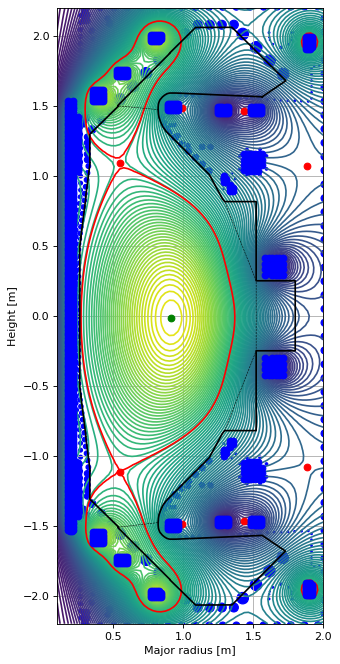

In [3]:
# Set initial equilibrium

# Assign current values to the active poloidal field coils 
# corresponding to a diverted plasma. 
# This assigns the passive structure currents too, in this specific case these are all set to zero.
import pickle
with open('simple_diverted_currents.pk', 'rb') as f:
    current_values = pickle.load(f)
for key in current_values.keys():
    eq.tokamak[key].current = current_values[key]

# Instantiate freeGSNKE static GS solver
from freegsnke import GSstaticsolver
# This requires use of the equilibrium itself to inform the solver of the domain and grid properties:
NK = GSstaticsolver.NKGSsolver(eq)
# Solve the forward GS problem corresponding to the tokamak metal currents set above and the requested profile properties
NK.solve(# The Equilibrium object sets the currents 
         eq, 
         # The profile sets the desired plasma properties
         profiles,
         # The relative tolerance set for convergence
         target_relative_tolerance=1e-8,
        #  max_solving_iterations=1,
         verbose=1)

# Plot the equilibrium
# As in freeGS, the full black line is the tokamak.wall.
# In addition, the thin black dotted line shows the tokamak.limiter,
# i.e. the border of the region where the plasma is allowed to be.
# The limiter is passed to the equilibrium object by the profile object during the NK.solve call. 
fig = plt.figure(figsize=(5, 10), dpi=80)
ax = fig.add_subplot(111)
ax.grid(True,which='both')
eq.plot(axis=ax,show=False)
eq.tokamak.plot(axis=ax,show=False)


In [4]:
# Initialize the time-evolutive solver Object.
# This uses an equilibrium object to inform the solver of the machine and domain properties.
# The solver object can be used on different equilibria/profiles, but these need to have the same 
# machine, domain and limiter properties as the one used in the instantiation.  
# The input equilibrium and profile functions are also used as the expansion point
# around which the dynamics is linearized. 
from freegsnke import nonlinear_solve
stepping = nonlinear_solve.nl_solver(# The equilibrium and profile around which the linearization is calculated 
                                     eq=eq, profiles=profiles, 
                                     # The timestep dt time is advanced by at every call of the stepper method
                                     full_timestep=3e-4, 
                                     # The resistivity of the plasma. This is assumed constant during the time evolution  
                                     plasma_resistivity=2e-6,
                                     )

# import functionality for quick calculation of plasma width, elongation, ect.
from freegsnke import faster_shape

Input max_mode_frequency corresponds to  29  independent vessel normal modes in addition to the  12  active coils.
I'm building the linearization wrt the currents. This may take a minute or two.
I'm building the linearization wrt the profile parameters.
Mode removal is ON: the input min_dIy_dI corresponds to keeping 25 out of the original 41 metal modes.
This equilibrium has a linear growth rate of 1/ 0.019201625199165222 s
The solver's timestep was set at 0.0003  as explicitly requested. Please compare this with the linear growth rate above and, if necessary, reset.


In [5]:
# For this example we will evolve a plasma in absence of any control policy or drive.
# The active voltages to apply to the poloidal field coils are calculated here using V=RI, 
# so to maintain the current values that define the initial equilibrium.
U_active = (stepping.vessel_currents_vec*stepping.evol_metal_curr.R)[:stepping.evol_metal_curr.n_active_coils] 


In [6]:
# First we evolve the plasma using the linearised dynamics.
# This is done by using linear_only = True in the stepper 

# Prepare the solver object by setting the initial conditions
stepping.initialize_from_ICs(eq, profiles)

# Set the total number of steps desired
max_count = 50

# Prepare for logging of the evolution
counter = 0
t = 0

history_times = [t]
history_currents = [stepping.currents_vec]
history_equilibria = [deepcopy(stepping.eq1)]
shapes = faster_shape.shapes_f(stepping.eq1, stepping.profiles1)
history_width = [shapes[0]]
history_o_points = shapes[1]
history_elongation = [shapes[2]]

while counter<max_count:
    clear_output(wait=True)
    display(f'Step: {counter}/{max_count-1}')
    display(f'current time t = {t}')
    
    t_start = time.time()

    # This is the actual call to the stepper
    # Note the use of the linearization: the plasma is advanced with respect to the linearised dynamics here
    stepping.nlstepper(active_voltage_vec = U_active, 
                       linear_only = True)       

    # Log information on the time-advanced plasma and currents:
    t += stepping.dt_step
    history_times.append(t)
    counter += 1
    # Time advanced currents are recorded in stepping.currents_vec
    history_currents.append(stepping.currents_vec)
    # The time advanced equilibrium and profile are recorded respectively in stepping.eq1 and stepping.profiles1
    history_equilibria.append(deepcopy(stepping.eq1))
    shapes = faster_shape.shapes_f(stepping.eq1, stepping.profiles1)
    history_width.append(shapes[0])
    history_o_points = np.append(history_o_points,shapes[1], axis=0)
    history_elongation.append(shapes[2])

# collect logs
history_currents = np.array(history_currents)
history_times = np.array(history_times)
history_o_points = np.array(history_o_points)


'Step: 49/49'

'current time t = 0.014699999999999998'

In [8]:
# Now we evolve the same plasma according to the full nonlinear dynamics, during the same time interval.
# This is done by using linear_only = False in the stepper 

# Reset the solver object by resetting the initial conditions
stepping.initialize_from_ICs(eq, profiles)

# Set the total number of steps desired
max_count = 50

# Prepare for logging of the evolution
counter = 0
t = 0

history_times_nl = [t]
history_currents_nl = [stepping.currents_vec]
history_equilibria_nl = [deepcopy(stepping.eq1)]
shapes = faster_shape.shapes_f(stepping.eq1, stepping.profiles1)
history_width_nl = [shapes[0]]
history_o_points_nl = shapes[1]
history_elongation_nl = [shapes[2]]

while counter<max_count:
    clear_output(wait=True)
    display(f'Step: {counter}/{max_count-1}')
    display(f'current time t = {t}')
    
    t_start = time.time()

    # This is the actual call to the stepper
    # Note the use of the nonlinear solver here
    stepping.nlstepper(active_voltage_vec = U_active, 
                       linear_only = False)       

    # Log information on the time-advanced plasma and currents:
    t += stepping.dt_step
    history_times_nl.append(t)
    counter += 1
    # Time advanced currents are recorded in stepping.currents_vec
    history_currents_nl.append(stepping.currents_vec)
    # The time advanced equilibrium and profile are recorded respectively in stepping.eq1 and stepping.profiles1
    history_equilibria_nl.append(deepcopy(stepping.eq1))
    shapes = faster_shape.shapes_f(stepping.eq1, stepping.profiles1)
    history_width_nl.append(shapes[0])
    history_o_points_nl = np.append(history_o_points_nl, shapes[1], axis=0)
    history_elongation_nl.append(shapes[2])

# collect logs
history_currents_nl = np.array(history_currents_nl)
history_times_nl = np.array(history_times_nl)
history_o_points_nl = np.array(history_o_points_nl)

'Step: 49/49'

'current time t = 0.014699999999999998'

Text(0.5, 1.0, 'Nonlinear')

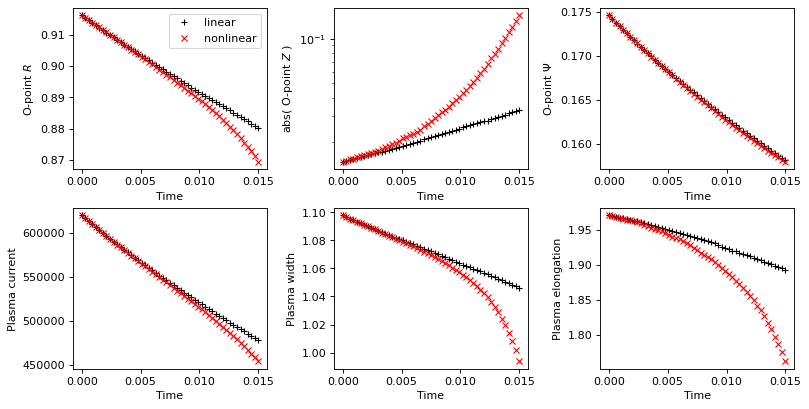

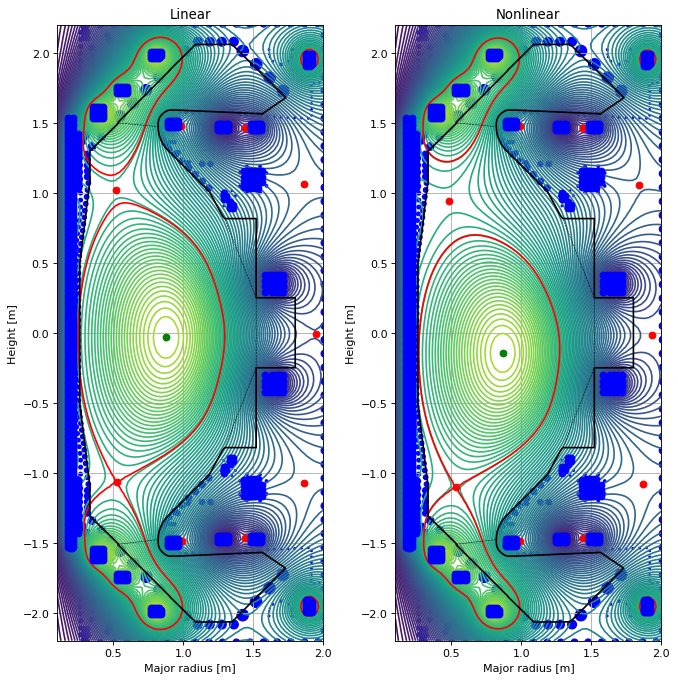

In [9]:
# Plot evolution of tracked values and compare between linear and non-linear evolution
fig, axs = plt.subplots(2, 3, figsize=(10, 5), dpi=80, constrained_layout=True)
axs_flat = axs.flat

axs_flat[0].plot(history_times, history_o_points[:, 0],'k+', label='linear')
axs_flat[0].plot(history_times_nl, history_o_points_nl[:, 0],'rx', label='nonlinear')
axs_flat[0].set_xlabel('Time')
axs_flat[0].set_ylabel('O-point $R$')
axs_flat[0].legend()

axs_flat[1].plot(history_times, abs(history_o_points[:, 1]),'k+')
axs_flat[1].plot(history_times_nl, abs(history_o_points_nl[:, 1]),'rx')
axs_flat[1].set_yscale('log')
axs_flat[1].set_xlabel('Time')
axs_flat[1].set_ylabel('abs( O-point $Z$ )')

axs_flat[2].plot(history_times, history_o_points[:, 2],'k+')
axs_flat[2].plot(history_times_nl, history_o_points_nl[:, 2],'rx')
axs_flat[2].set_xlabel('Time')
axs_flat[2].set_ylabel('O-point $\Psi$')

axs_flat[3].plot(history_times, history_currents[:,-1]*stepping.plasma_norm_factor,'k+')
axs_flat[3].plot(history_times_nl, history_currents_nl[:,-1]*stepping.plasma_norm_factor,'rx')
axs_flat[3].set_xlabel('Time')
axs_flat[3].set_ylabel('Plasma current')

axs_flat[4].plot(history_times, history_width,'k+')
axs_flat[4].plot(history_times_nl, history_width_nl,'rx')
axs_flat[4].set_xlabel('Time')
axs_flat[4].set_ylabel('Plasma width')

axs_flat[5].plot(history_times, history_elongation,'k+')
axs_flat[5].plot(history_times_nl, history_elongation_nl,'rx')
axs_flat[5].set_xlabel('Time')
axs_flat[5].set_ylabel('Plasma elongation')

# Plot equilibria at last simulated time
fig = plt.figure(figsize=(10, 10), dpi=80)
ax = fig.add_subplot(121)
ax.grid(True,which='both')
history_equilibria[-1].plot(axis=ax,show=False)
eq.tokamak.plot(axis=ax,show=False)
plt.title('Linear')
ax = fig.add_subplot(122)
ax.grid(True,which='both')
history_equilibria_nl[-1].plot(axis=ax,show=False)
eq.tokamak.plot(axis=ax,show=False)
plt.title('Nonlinear')

